## Multicolinearity

It is often not a good idea to use every feature variable you have in the statistical model. Not only can this cause overfitting, but if the feature variables are highly correlated it can make inference difficult.

Lets make some fake data to learn more about the pitfalls of multicolinearity. Lets simulate height data and see if we can predict it using the length of the left and the right leg. We will add a little bit of variance so the lengths of the left and right leg aren't exactly the same but highly correlated.

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as graph

graph.style.use('fivethirtyeight')

In [28]:
# Simulate data
n = 100
height = stats.norm.rvs(loc=10, scale=2, size=n)
perc_leg = stats.uniform.rvs(loc=0.40, scale=0.5, size=n)

left_leg = height * perc_leg + stats.norm.rvs(loc=0, scale=0.02, size=n)
right_leg = height * perc_leg + stats.norm.rvs(loc=0, scale=0.02, size=n)

df = pd.DataFrame({'height': height, 'left_leg': left_leg, 'right_leg': right_leg})
df.head()

,height,left_leg,right_leg
0,11.863604,8.424078,8.457962
1,11.016424,9.640674,9.656597
2,12.944699,7.149605,7.129141
3,8.718136,5.371945,5.374064
4,12.450836,10.365516,10.395433


/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


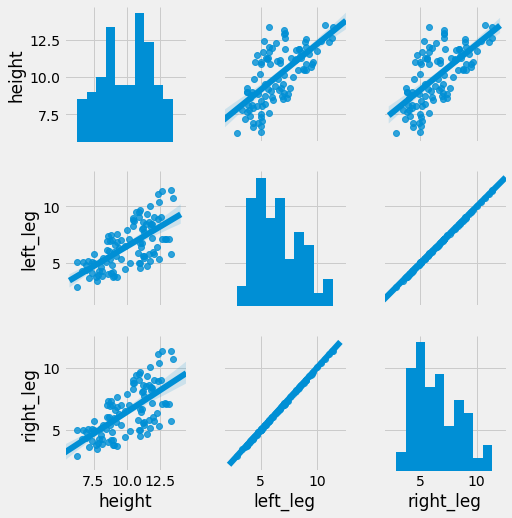

In [29]:
# Plot data
sns.pairplot(df, kind='reg')
graph.show()

As we can see the left and right leg variables are highly correlated. Moreover they seem to have the same relationship with height. Now lets do some inference first with a single variable then with both.

INFO (theano.gof.compilelock): Refreshing lock /home/harshil/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 692.86draws/s]
The acceptance probability does not match the target. It is 0.9030336677877081, but should be close to 0.8. Try to increase the number of tuning steps.


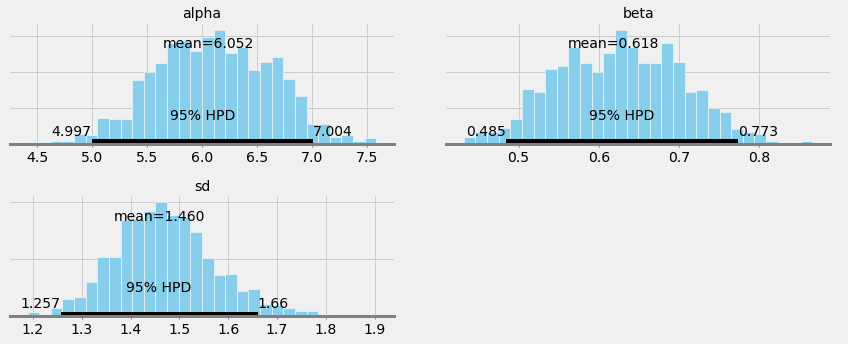

In [30]:
with pm.Model() as single_model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta = pm.Normal('beta', 0, 100)
    sd = pm.Uniform('sd', 0, 100)
    
    # Linear relationship
    mu = alpha + beta * df['left_leg']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['height'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)
    graph.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_right, beta_left, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [02:04<00:00, 16.12draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


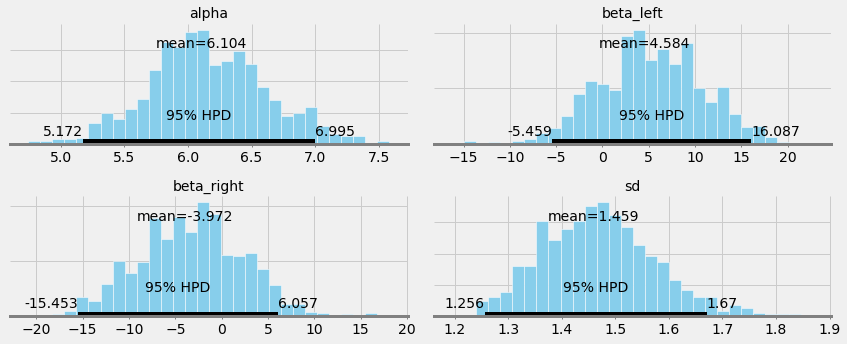

In [31]:
with pm.Model() as both_model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta_left = pm.Normal('beta_left', 0, 100)
    beta_right = pm.Normal('beta_right', 0, 100)
    sd = pm.Uniform('sd', 0, 100)
    
    # Linear relationship
    mu = alpha + beta_left * df['left_leg'] + beta_right * df['right_leg']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['height'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)
    graph.show()

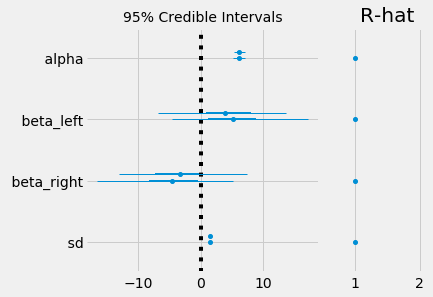

In [32]:
pm.forestplot(trace)
graph.show()

These results are weird! The variance in the posterior distributions for the effects of the legs is huge. Why? Well multiple linear regression asks the question what is the value of knowing each legs length after already knowing the other legs length? The problem here is that there is an infinite number of combinations the two beta_left and beta_right values can take to produce the same likelihood.

When a high beta_right value is sampled, low beta_left values will have higher likelihoods so will be sampled more. Therefore the two betas should be highly correlated and we can look at the joint distribution of the posterior betas to observe this.

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


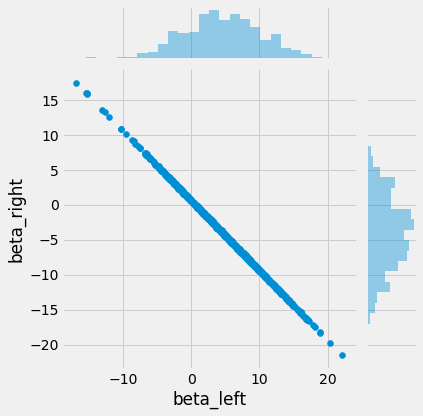

In [33]:
trace_df = pm.trace_to_dataframe(trace)

sns.jointplot(trace_df['beta_left'], trace_df['beta_right'])
graph.show()

Essentially including both beta_left and beta_right in the model means an infinite combination of the two will produce the same prediction. 

This is the same as modeling height as 

${ h_i = \mathcal{N}(\mu, \sigma) }$

${ \mu = \alpha + \beta_1 * left\_leg\_length + \beta_2 * left\_leg\_length }$

notice here that left_leg_length is used twice to predict height with a different beta term each time
which is equivalent to : 

${ \mu = \alpha + (\beta_1 + \beta_2) * left\_leg\_length }$

Intuitively you can see that many different beta_1 and beta_2 values can produce the same sum of beta_1 and beta_2 values. This means the model will be unsure of what the true value for beta_1 is since having beta_2 in the model adds many more plausible values for beta_1

Lets sum the posterior distributions for beta_left and beta_right

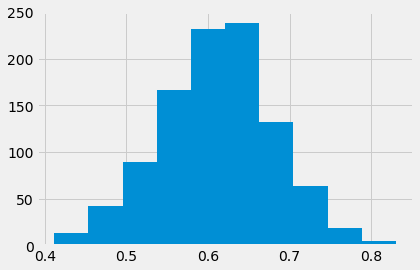

In [34]:
graph.hist(trace_df['beta_left'] + trace_df['beta_right'])
graph.show()

We can see that the sum of the two beta_left and beta_right distributions are centered around 0.6, looking a lot like the posterior distribution for when beta_left was the only parameter in the model. This further shows that the effect of leg length is 0.6, but having both terms in the model adds more plausible values for each beta term increasing its variance drastically.

Note: The model with both terms will be near impossible to interpret but it will make good predictions so if that's all youre looking this particular issue isn't as big of a problem, although overfitting may be.  

# Multicolinearity in a real dataset

Let's analyze the milk and brain dataset while looking out for multicolinearity

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv', sep=';')
df.columns = [col.replace('.', '-') for col in df.columns]
df.dropna(inplace=True)

print(df.shape)
df.head()

(17, 8)


,clade,species,kcal-per-g,perc-fat,perc-protein,perc-lactose,mass,neocortex-perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


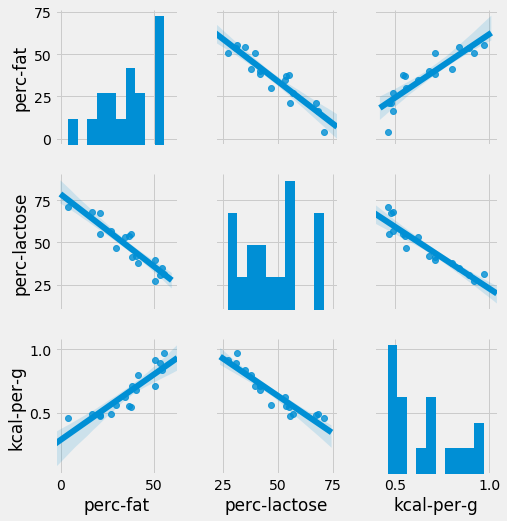

In [39]:
sns.pairplot(df[['perc-fat', 'perc-lactose', 'kcal-per-g']], kind='reg')
graph.show()

Here percent-fat and percent-lactose are negatively correlated but each is either negatively or positvely correlated with kcal-per-gram. Lets try to predict kcal-per-gram with percent-fat and percent-lactose first individually then together.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_fat, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 399.20draws/s]


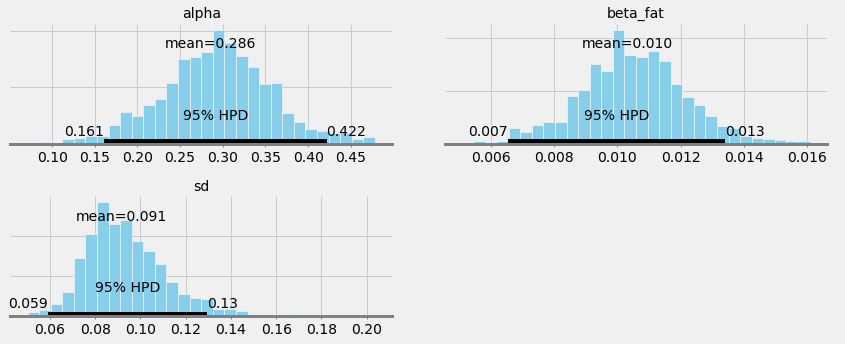

In [47]:
with pm.Model() as fat_model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta_fat = pm.Normal('beta_fat', 0, 100)
    sd = pm.Uniform('sd', 0, 100)
    
    # Linear relationship
    mu = alpha + beta_fat * df['perc-fat']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['kcal-per-g'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_lact, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 363.26draws/s]
The acceptance probability does not match the target. It is 0.8988306790833326, but should be close to 0.8. Try to increase the number of tuning steps.


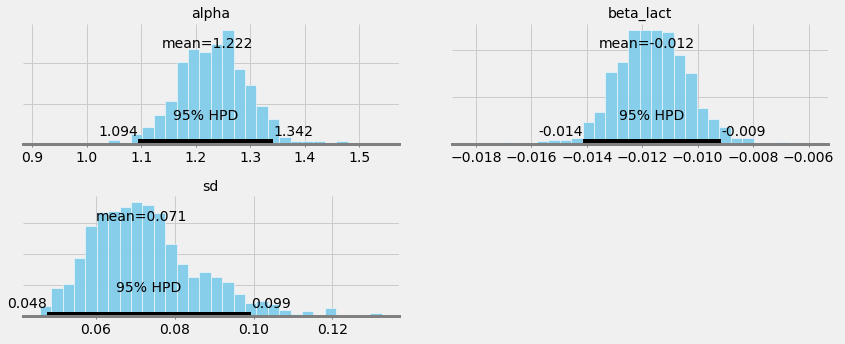

In [44]:
with pm.Model() as lactose_model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta_lact = pm.Normal('beta_lact', 0, 100)
    sd = pm.Uniform('sd', 0, 100)
    
    # Linear relationship
    mu = alpha + beta_lact * df['perc-lactose']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['kcal-per-g'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/harshil/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_lact, beta_fat, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:11<00:00, 172.73draws/s]
The acceptance probability does not match the target. It is 0.8961899076903708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.919817381471523, but should be close to 0.8. Try to increase the number of tuning steps.


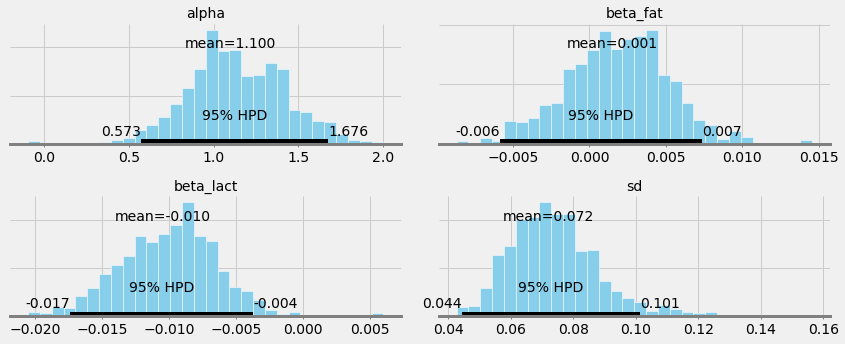

In [46]:
with pm.Model() as both_model:
    # Priors
    alpha = pm.Normal('alpha', 0, 100)
    beta_fat = pm.Normal('beta_fat', 0, 100)
    beta_lact = pm.Normal('beta_lact', 0, 100)
    sd = pm.Uniform('sd', 0, 100)
    
    # Linear relationship
    mu = alpha + beta_fat * df['perc-fat'] + beta_lact * df['perc-lactose']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['kcal-per-g'])
    
    # Sample
    trace = pm.sample()
    
    # Posterior
    pm.plot_posterior(trace)

We can see the large uncertainty in the posterior distribution between the model with both features and the models with individual features. 